In [1]:
import os
import time
import random

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
)

import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Cố định random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)



Đọc dữ liệu & chuẩn bị text (body)


In [2]:
DATA_PATH = "dataset/clean_data.csv"  

df = pd.read_csv(DATA_PATH)
print("Kích thước dữ liệu ban đầu:", df.shape)
df.head()


Kích thước dữ liệu ban đầu: (11383, 8)


,title,lead,body,url,subject,published_at,source,original_subject
0,Tổng Bí thư: Chọn nhân sự Bộ Chính trị khóa 14...,Tổng Bí thư Tô Lâm nhấn mạnh nhân sự Bộ Chính ...,"Sáng 5/11, phát biểu khai mạc Hội nghị Trung ư...",https://vnexpress.net/tong-bi-thu-chon-nhan-su...,Chính trị,2025-11-05T09:54:00-07:00,vnexpress,Chính trị
1,Khai mạc Hội nghị Trung ương 14,Hội nghị lần thứ 14 Ban Chấp hành Trung ương k...,"Tại phiên khai mạc, Tổng Bí thư Tô Lâm chủ trì...",https://vnexpress.net/khai-mac-hoi-nghi-trung-...,Chính trị,2025-11-05T09:02:00-07:00,vnexpress,Chính trị
2,Tổng Bí thư: Không để người dân phải xin những...,Tổng Bí thư Tô Lâm nhấn mạnh Nhà nước pháp quy...,"Chiều 4/11, phát biểu trước Quốc hội về những ...",https://vnexpress.net/tong-bi-thu-khong-de-ngu...,Chính trị,2025-11-04T17:01:00-07:00,vnexpress,Chính trị
3,Phó chánh án Nguyễn Quốc Đoàn làm Phó tổng Tha...,"Ngày 4/11, Thủ tướng bổ nhiệm ông Nguyễn Quốc ...",Ông Đoàn đảm nhiệm cương vị mới thay ông Nguyễ...,https://vnexpress.net/pho-chanh-an-nguyen-quoc...,Chính trị,2025-11-04T16:42:00-07:00,vnexpress,Chính trị
4,Ông Nguyễn Văn Quảng làm Bí thư Đảng ủy Tòa án...,"Ông Nguyễn Văn Quảng, Phó tổng thường trực Tha...","Chiều 4/11, Ban Thường vụ Đảng ủy các cơ quan ...",https://vnexpress.net/ong-nguyen-van-quang-lam...,Chính trị,2025-11-04T15:58:00-07:00,vnexpress,Chính trị


In [3]:
# Chỉ giữ cột body và subject cho bài toán phân loại
REQUIRED_COLS = ["body", "subject"]
df = df[REQUIRED_COLS].dropna(subset=["body", "subject"]).reset_index(drop=True)

print("Kích thước sau khi chọn cột & bỏ NA:", df.shape)

# Tạo cột text dùng trong mô hình 
df["text_body"] = df["body"].fillna("")

print("\nVí dụ body (400 ký tự đầu):")
print(df["text_body"].iloc[0][:400], "...")

Kích thước sau khi chọn cột & bỏ NA: (11383, 2)

Ví dụ body (400 ký tự đầu):
Sáng 5/11, phát biểu khai mạc Hội nghị Trung ương 14, Tổng Bí thư Tô Lâm cho biết tại Hội nghị Trung ương 13, trên cơ sở đề nghị của Bộ Chính trị, Ban Chấp hành Trung ương khóa 13 đã biểu quyết thống nhất, tập trung cao, giới thiệu nhân sự Ban Chấp hành Trung ương khóa 14 - chưa bao gồm các Ủy viên Bộ Chính trị, Ủy viên Ban Bí thư đủ điều kiện tái cử và các trường hợp đặc biệt. Nhân sự được giới t ...


In [4]:
print("Phân bố nhãn (subject):")
print(df["subject"].value_counts())

Phân bố nhãn (subject):
subject
Sức khỏe              1096
Kinh doanh            1094
Pháp luật             1062
Giải trí              1049
Thể thao              1029
Đời sống              1029
Chính trị             1020
Du lịch               1011
Khoa học công nghệ    1008
Thế giới              1006
Giáo dục               979
Name: count, dtype: int64


In [6]:
print("Phân bố nhãn (subject):")
print(df["subject"].value_counts())


Phân bố nhãn (subject):
subject
Sức khỏe              1096
Kinh doanh            1094
Pháp luật             1062
Giải trí              1049
Thể thao              1029
Đời sống              1029
Chính trị             1020
Du lịch               1011
Khoa học công nghệ    1008
Thế giới              1006
Giáo dục               979
Name: count, dtype: int64


Chia train / val / test

In [7]:
TEXT_COL = "text_body"
LABEL_COL = "subject"

X_all = df[TEXT_COL].values
y_all = df[LABEL_COL].values

# train_val / test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_all,
    y_all,
    test_size=0.10,
    random_state=RANDOM_STATE,
    stratify=y_all,
)

# train / val từ train_val
val_size = 0.10 / 0.90
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=val_size,
    random_state=RANDOM_STATE,
    stratify=y_train_val,
)

print(f"Số mẫu train: {len(X_train)}")
print(f"Số mẫu val:   {len(X_val)}")
print(f"Số mẫu test:  {len(X_test)}")


Số mẫu train: 9105
Số mẫu val:   1139
Số mẫu test:  1139


In [8]:
def show_label_distribution(name, labels):
    print(f"\n== Phân bố nhãn trong {name} ==")
    print(pd.Series(labels).value_counts().sort_index())


show_label_distribution("train", y_train)
show_label_distribution("val", y_val)
show_label_distribution("test", y_test)



== Phân bố nhãn trong train ==
Chính trị             816
Du lịch               809
Giáo dục              783
Giải trí              839
Khoa học công nghệ    806
Kinh doanh            876
Pháp luật             850
Sức khỏe              876
Thế giới              804
Thể thao              823
Đời sống              823
Name: count, dtype: int64

== Phân bố nhãn trong val ==
Chính trị             102
Du lịch               101
Giáo dục               98
Giải trí              105
Khoa học công nghệ    101
Kinh doanh            109
Pháp luật             106
Sức khỏe              110
Thế giới              101
Thể thao              103
Đời sống              103
Name: count, dtype: int64

== Phân bố nhãn trong test ==
Chính trị             102
Du lịch               101
Giáo dục               98
Giải trí              105
Khoa học công nghệ    101
Kinh doanh            109
Pháp luật             106
Sức khỏe              110
Thế giới              101
Thể thao              103
Đời sống              1

Định nghĩa TF-IDF và các mô hình baseline

In [9]:
tfidf_params = dict(
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True,
)

models = {
    "tfidf_nb": Pipeline(
        steps=[
            ("tfidf", TfidfVectorizer(**tfidf_params)),
            ("clf", MultinomialNB()),
        ]
    ),
    "tfidf_linearsvc": Pipeline(
        steps=[
            ("tfidf", TfidfVectorizer(**tfidf_params)),
            ("clf", LinearSVC(C=1.0, random_state=RANDOM_STATE)),
        ]
    ),
    "tfidf_logreg": Pipeline(
        steps=[
            ("tfidf", TfidfVectorizer(**tfidf_params)),
            (
                "clf",
                LogisticRegression(
                    max_iter=1000,
                    n_jobs=-1,
                    random_state=RANDOM_STATE,
                ),
            ),
        ]
    ),
}

print("Các mô hình sẽ so sánh:")
for name in models:
    print("-", name)


Các mô hình sẽ so sánh:
- tfidf_nb
- tfidf_linearsvc
- tfidf_logreg


Huấn luyện & đánh giá từng mô hình

In [10]:
# Khởi tạo biến lưu kết quả
results = []
detailed_preds = {}  

Train và evaluate model Logistic Regression

In [11]:
model_name = "tfidf_logreg"
model = models[model_name]

print(f"ĐANG HUẤN LUYỆN MÔ HÌNH: {model_name}")

start_time = time.time()
model.fit(X_train, y_train)
train_time = time.time() - start_time

# Dự đoán
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)
detailed_preds[model_name] = y_test_pred

# Tính metric
val_acc = accuracy_score(y_val, y_val_pred)
val_f1_macro = f1_score(y_val, y_val_pred, average="macro")

test_acc = accuracy_score(y_test, y_test_pred)
test_f1_macro = f1_score(y_test, y_test_pred, average="macro")
test_f1_weighted = f1_score(y_test, y_test_pred, average="weighted")

results.append(
    {
        "model": model_name,
        "val_accuracy": val_acc,
        "val_f1_macro": val_f1_macro,
        "test_accuracy": test_acc,
        "test_f1_macro": test_f1_macro,
        "test_f1_weighted": test_f1_weighted,
        "train_time_s": train_time,
    }
)

# In tóm tắt
print(f"Thời gian train:   {train_time:.2f} s")
print(f"Val Accuracy:      {val_acc:.4f}")
print(f"Val F1-macro:      {val_f1_macro:.4f}")
print(f"Test Accuracy:     {test_acc:.4f}")
print(f"Test F1-macro:     {test_f1_macro:.4f}")
print(f"Test F1-weighted:  {test_f1_weighted:.4f}")

print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))


ĐANG HUẤN LUYỆN MÔ HÌNH: tfidf_logreg
Thời gian train:   29.02 s
Val Accuracy:      0.8788
Val F1-macro:      0.8789
Test Accuracy:     0.8762
Test F1-macro:     0.8763
Test F1-weighted:  0.8761

Classification report (test):
                    precision    recall  f1-score   support

         Chính trị       0.82      0.82      0.82       102
           Du lịch       0.88      0.91      0.89       101
          Giáo dục       0.93      0.87      0.90        98
          Giải trí       0.90      0.92      0.91       105
Khoa học công nghệ       0.87      0.84      0.85       101
        Kinh doanh       0.78      0.79      0.79       109
         Pháp luật       0.91      0.92      0.91       106
          Sức khỏe       0.88      0.95      0.92       110
          Thế giới       0.92      0.89      0.90       101
          Thể thao       0.99      0.96      0.98       103
          Đời sống       0.77      0.76      0.76       103

          accuracy                           0.88   

Huấn luyện LinearSVC

In [12]:
# Train LinearSVC
model_name = "tfidf_linearsvc"
model = models[model_name]

print(f"ĐANG HUẤN LUYỆN MÔ HÌNH: {model_name}")

start_time = time.time()
model.fit(X_train, y_train)
train_time = time.time() - start_time

# Dự đoán
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)
detailed_preds[model_name] = y_test_pred

# Tính metric
val_acc = accuracy_score(y_val, y_val_pred)
val_f1_macro = f1_score(y_val, y_val_pred, average="macro")

test_acc = accuracy_score(y_test, y_test_pred)
test_f1_macro = f1_score(y_test, y_test_pred, average="macro")
test_f1_weighted = f1_score(y_test, y_test_pred, average="weighted")

results.append(
    {
        "model": model_name,
        "val_accuracy": val_acc,
        "val_f1_macro": val_f1_macro,
        "test_accuracy": test_acc,
        "test_f1_macro": test_f1_macro,
        "test_f1_weighted": test_f1_weighted,
        "train_time_s": train_time,
    }
)

# In tóm tắt
print(f"Thời gian train:   {train_time:.2f} s")
print(f"Val Accuracy:      {val_acc:.4f}")
print(f"Val F1-macro:      {val_f1_macro:.4f}")
print(f"Test Accuracy:     {test_acc:.4f}")
print(f"Test F1-macro:     {test_f1_macro:.4f}")
print(f"Test F1-weighted:  {test_f1_weighted:.4f}")

print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))

ĐANG HUẤN LUYỆN MÔ HÌNH: tfidf_linearsvc
Thời gian train:   10.26 s
Val Accuracy:      0.9183
Val F1-macro:      0.9182
Test Accuracy:     0.9140
Test F1-macro:     0.9137
Test F1-weighted:  0.9136

Classification report (test):
                    precision    recall  f1-score   support

         Chính trị       0.85      0.91      0.88       102
           Du lịch       0.92      0.96      0.94       101
          Giáo dục       0.93      0.87      0.90        98
          Giải trí       0.94      0.96      0.95       105
Khoa học công nghệ       0.93      0.90      0.91       101
        Kinh doanh       0.83      0.88      0.86       109
         Pháp luật       0.94      0.92      0.93       106
          Sức khỏe       0.89      0.97      0.93       110
          Thế giới       0.97      0.91      0.94       101
          Thể thao       0.98      0.99      0.99       103
          Đời sống       0.87      0.78      0.82       103

          accuracy                           0.91

Huấn luyện Multinomial Naive Bayes

In [13]:
# Train MultinomialNB
model_name = "tfidf_nb"
model = models[model_name]

print(f"ĐANG HUẤN LUYỆN MÔ HÌNH: {model_name}")

start_time = time.time()
model.fit(X_train, y_train)
train_time = time.time() - start_time

# Dự đoán
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)
detailed_preds[model_name] = y_test_pred

# Tính metric
val_acc = accuracy_score(y_val, y_val_pred)
val_f1_macro = f1_score(y_val, y_val_pred, average="macro")

test_acc = accuracy_score(y_test, y_test_pred)
test_f1_macro = f1_score(y_test, y_test_pred, average="macro")
test_f1_weighted = f1_score(y_test, y_test_pred, average="weighted")

results.append(
    {
        "model": model_name,
        "val_accuracy": val_acc,
        "val_f1_macro": val_f1_macro,
        "test_accuracy": test_acc,
        "test_f1_macro": test_f1_macro,
        "test_f1_weighted": test_f1_weighted,
        "train_time_s": train_time,
    }
)

# In tóm tắt
print(f"Thời gian train:   {train_time:.2f} s")
print(f"Val Accuracy:      {val_acc:.4f}")
print(f"Val F1-macro:      {val_f1_macro:.4f}")
print(f"Test Accuracy:     {test_acc:.4f}")
print(f"Test F1-macro:     {test_f1_macro:.4f}")
print(f"Test F1-weighted:  {test_f1_weighted:.4f}")

print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))

ĐANG HUẤN LUYỆN MÔ HÌNH: tfidf_nb
Thời gian train:   8.25 s
Val Accuracy:      0.8332
Val F1-macro:      0.8330
Test Accuracy:     0.8367
Test F1-macro:     0.8367
Test F1-weighted:  0.8366

Classification report (test):
                    precision    recall  f1-score   support

         Chính trị       0.73      0.86      0.79       102
           Du lịch       0.81      0.82      0.81       101
          Giáo dục       0.96      0.82      0.88        98
          Giải trí       0.86      0.96      0.91       105
Khoa học công nghệ       0.90      0.75      0.82       101
        Kinh doanh       0.65      0.83      0.73       109
         Pháp luật       0.85      0.92      0.88       106
          Sức khỏe       0.87      0.91      0.89       110
          Thế giới       0.92      0.82      0.87       101
          Thể thao       1.00      0.92      0.96       103
          Đời sống       0.77      0.57      0.66       103

          accuracy                           0.84      11

Bảng so sánh các mô hình

In [14]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("test_f1_macro", ascending=False).reset_index(drop=True)

print("Bảng so sánh các mô hình (sắp xếp theo Test F1-macro giảm dần):")
results_df


Bảng so sánh các mô hình (sắp xếp theo Test F1-macro giảm dần):


,model,val_accuracy,val_f1_macro,test_accuracy,test_f1_macro,test_f1_weighted,train_time_s
0,tfidf_linearsvc,0.918349,0.918157,0.913960,0.913704,0.913612,10.258775
1,tfidf_logreg,0.878841,0.878933,0.876207,0.876281,0.876108,29.017886
2,tfidf_nb,0.833187,0.833014,0.836699,0.836713,0.836557,8.245158


Vẽ bar chart Test F1-macro

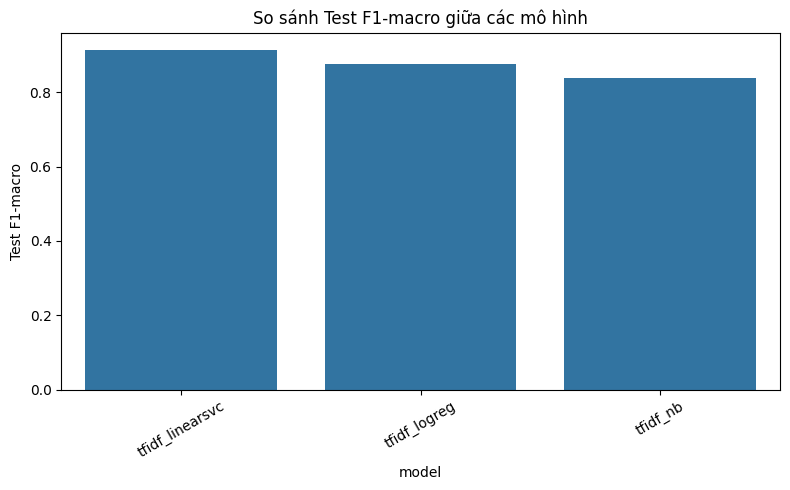

In [15]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=results_df,
    x="model",
    y="test_f1_macro",
)
plt.ylabel("Test F1-macro")
plt.title("So sánh Test F1-macro giữa các mô hình")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


Chọn mô hình tốt nhất & vẽ confusion matrix

Mô hình tốt nhất theo Test F1-macro:
model               tfidf_linearsvc
val_accuracy               0.918349
val_f1_macro               0.918157
test_accuracy               0.91396
test_f1_macro              0.913704
test_f1_weighted           0.913612
train_time_s              10.258775
Name: 0, dtype: object


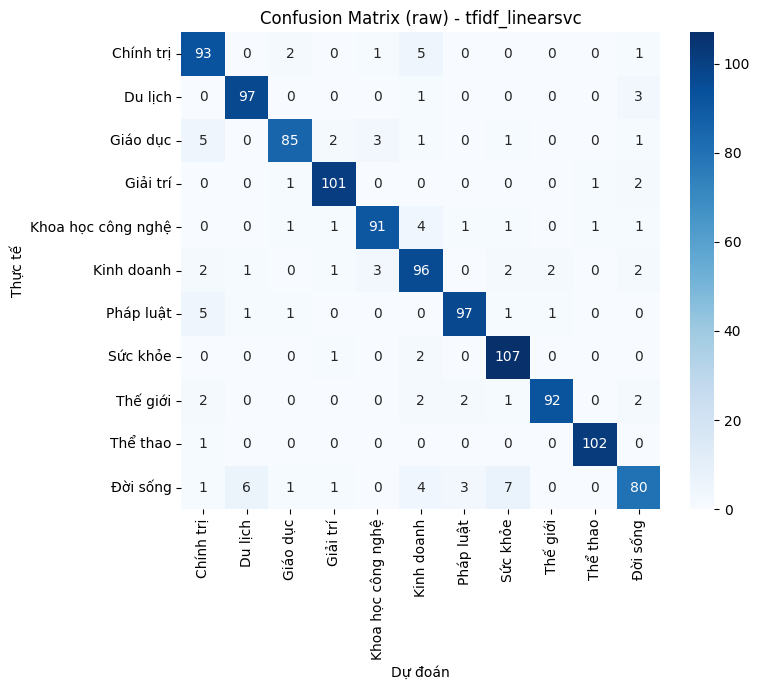

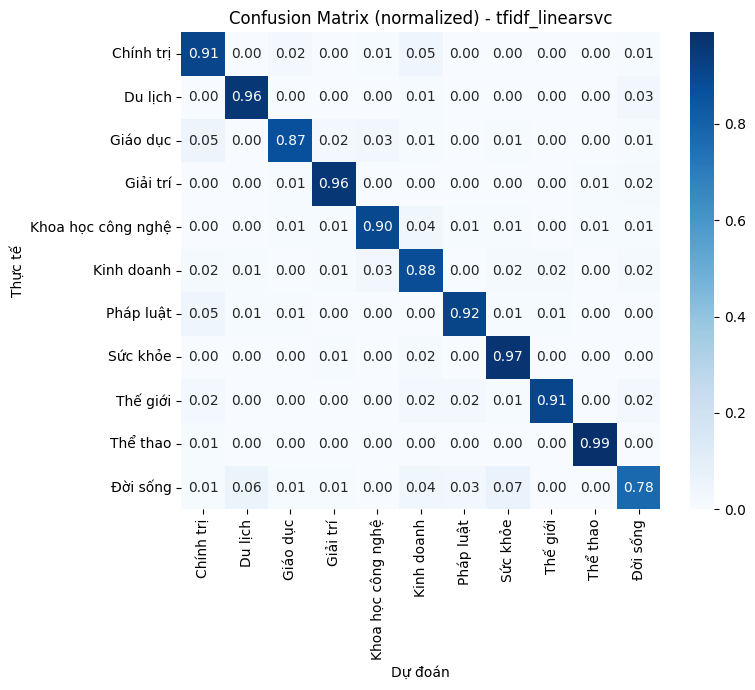

In [16]:
best_row = results_df.iloc[0]
best_name = best_row["model"]
best_model = models[best_name]

print("Mô hình tốt nhất theo Test F1-macro:")
print(best_row)

y_test_pred_best = detailed_preds[best_name]
labels = sorted(np.unique(y_test))
label_names = labels

# Confusion matrix (raw)
cm = confusion_matrix(y_test, y_test_pred_best, labels=labels)

plt.figure(figsize=(8, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.title(f"Confusion Matrix (raw) - {best_name}")
plt.tight_layout()
plt.show()

# Confusion matrix (normalized theo hàng)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 7))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.title(f"Confusion Matrix (normalized) - {best_name}")
plt.tight_layout()
plt.show()


In [17]:
# Lưu mô hình tốt nhất
model_save_path = "models/best_model.pkl"

# Tạo thư mục nếu chưa tồn tại
os.makedirs("models", exist_ok=True)

# Lưu mô hình
joblib.dump(best_model, model_save_path)

print(f"Đã lưu mô hình tốt nhất ({best_name}) vào: {model_save_path}")
print(f"Test F1-macro: {best_row['test_f1_macro']:.4f}")
print(f"Test Accuracy: {best_row['test_accuracy']:.4f}")

Đã lưu mô hình tốt nhất (tfidf_linearsvc) vào: models/best_model.pkl
Test F1-macro: 0.9137
Test Accuracy: 0.9140


In [18]:
import joblib
import numpy as np

MODEL_PATH = "models/best_model.pkl"

# Load pipeline TF-IDF + LinearSVC
tfidf_clf = joblib.load(MODEL_PATH)

def classify_news_tfidf(text: str):
    """
    text: body (hoặc title+lead+body) của bài báo
    """
    pred_id = tfidf_clf.predict([text])[0]
    # nếu bạn có label_encoder thì giải mã về tên nhãn
    try:
        label_encoder = joblib.load("models/label_encoder_cls.pkl")
        pred_label = label_encoder.inverse_transform([pred_id])[0]
    except Exception:
        pred_label = pred_id  # trường hợp bạn lưu trực tiếp là string label

    # Lấy decision function để xem score (không phải xác suất)
    try:
        scores = tfidf_clf.decision_function([text])[0]
        top_k = 3
        top_ids = np.argsort(scores)[::-1][:top_k]
        top_scores = scores[top_ids]
    except Exception:
        top_ids, top_scores = None, None

    return pred_label, top_ids, top_scores

# ==== TEST THỬ ====
sample_body = """
Ông Trump: Venezuela muốn đàm phán
Tổng thống Trump nói có thể đàm phán với người đồng cấp Maduro, sau khi Mỹ triển khai lực lượng quân sự lớn ở ngoài khơi Venezuela.

"Venezuela muốn đàm phán. Chúng ta có thể thảo luận với ông Maduro và chờ xem kết quả sẽ ra sao", Tổng thống Mỹ Donald Trump nói ngày 16/11, đề cập tới người đồng cấp Venezuela Nicolas Maduro.

Ông Trump không cung cấp thêm thông tin chi tiết về khả năng đàm phán với ông Maduro, người mà Mỹ cáo buộc "có liên quan tới hoạt động buôn bán ma túy". Tổng thống Maduro bác bỏ cáo buộc này, cho rằng đây là cái cớ để Mỹ triển khai lực lượng quân sự lớn gần Venezuela.
"""

pred_label, top_ids, top_scores = classify_news_tfidf(sample_body)
print("➡ Chủ đề dự đoán (TF-IDF + LinearSVC):", pred_label)

if top_ids is not None:
    print("\nTop-3 lớp có score cao nhất:")
    for cls_id, score in zip(top_ids, top_scores):
        print(f"- Lớp {cls_id}: score = {score:.3f}")


➡ Chủ đề dự đoán (TF-IDF + LinearSVC): Thế giới

Top-3 lớp có score cao nhất:
- Lớp 8: score = 0.426
- Lớp 5: score = -0.891
- Lớp 6: score = -0.970
